In [1]:
import os
import pandas as pd
from torchkge.data_structures import KnowledgeGraph
from torchkge.models import TransEModel


/root/anaconda3/envs/openke/lib/python3.10/site-packages/torchkge/utils/data_redundancy.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## 示例

In [2]:
from torchkge.utils.datasets import load_fb15k
kg_train, _, _ = load_fb15k()


In [3]:
kg_train

In [4]:
df = kg_train.get_df()

In [5]:
df

,from,to,rel
0,/m/027rn,/m/06cx9,/location/country/form_of_government
1,/m/017dcd,/m/06v8s0,/tv/tv_program/regular_cast./tv/regular_tv_app...
2,/m/07s9rl0,/m/0170z3,/media_common/netflix_genre/titles
3,/m/01sl1q,/m/044mz_,/award/award_winner/awards_won./award/award_ho...
4,/m/0cnk2q,/m/02nzb8,/soccer/football_team/current_roster./sports/s...
...,...,...,...
483137,/m/0gpx6,/m/0gq6s3,/award/award_nominated_work/award_nominations....
483138,/m/020jqv,/m/09d3b7,/award/award_nominee/award_nominations./award/...
483139,/m/0524b41,/m/0lp_cd3,/award/award_winning_work/awards_won./award/aw...
483140,/m/0kvsb,/m/050xpd,/people/person/education./education/education/...


## OpenBG500

### 2.1 读取数据

In [6]:
import pandas as pd

In [7]:
df_train = pd.read_csv("./train.csv")
df_test = pd.read_csv("./test.csv")

In [8]:
df_train

,head,relation,tail
0,婴儿围嘴,文胸尺码,16*10CM*2个
1,大码内衣女超薄款大胸显小神器缩胸防下垂文胸胖mm200斤胸罩夏季,文胸尺码,如担心下围短，可联系客服送排扣
2,卫衣,文胸尺码,均
3,卫衣,文胸尺码,不加绒
4,诺瓦纳内衣,文胸尺码,S下胸围65-80
...,...,...,...
8702,立式消毒柜,门数量,双门
8703,新款便携式高密度支架睡帐-玉,门数量,3门
8704,蚊帐,门数量,3门
8705,法兰绒被套,门数量,双门


In [9]:
df_train = df_train.rename(columns = {"head":"from" , "relation":"rel", "tail": "to"})
df_test = df_test.rename(columns = {"head":"from" , "relation":"rel", "tail": "to"})

In [10]:
df_train

,from,rel,to
0,婴儿围嘴,文胸尺码,16*10CM*2个
1,大码内衣女超薄款大胸显小神器缩胸防下垂文胸胖mm200斤胸罩夏季,文胸尺码,如担心下围短，可联系客服送排扣
2,卫衣,文胸尺码,均
3,卫衣,文胸尺码,不加绒
4,诺瓦纳内衣,文胸尺码,S下胸围65-80
...,...,...,...
8702,立式消毒柜,门数量,双门
8703,新款便携式高密度支架睡帐-玉,门数量,3门
8704,蚊帐,门数量,3门
8705,法兰绒被套,门数量,双门


In [11]:
from torchkge.data_structures import KnowledgeGraph

In [12]:
kg = KnowledgeGraph(df=df_train)
print("实体数:", kg.n_ent, "关系数:", kg.n_rel, "训练数:", kg.n_facts)

实体数: 4562 关系数: 131 训练数: 8707


In [13]:
kg

### 2.2 准备训练

In [15]:
emb_dim = 100
lr = 0.0004
n_epochs = 1000
b_size = 256
margin = 0.5

## TransE

In [16]:
from torchkge.utils import MarginLoss, DataLoader
from torchkge.models import TransEModel
from torch import cuda
from torch.optim import Adam
from torchkge.utils import MarginLoss, DataLoader
from tqdm.autonotebook import tqdm
from torchkge.sampling import BernoulliNegativeSampler

In [17]:
# Define the model and criterion
model = TransEModel(emb_dim, kg.n_ent, kg.n_rel, dissimilarity_type='L2')
criterion = MarginLoss(margin)

In [18]:
# Move everything to CUDA if available
if cuda.is_available():
    cuda.empty_cache()
    model.cuda()
    criterion.cuda()


In [22]:
# Define the torch optimizer to be used
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)

sampler = BernoulliNegativeSampler(kg)
dataloader = DataLoader(kg, batch_size=b_size, )

In [23]:
iterator = tqdm(range(n_epochs), unit='epoch')
epoch_losses = []
for epoch in iterator:
    running_loss = 0.0
    for i, batch in enumerate(dataloader):
        h, t, r = batch[0], batch[1], batch[2]
        n_h, n_t = sampler.corrupt_batch(h, t, r)

        optimizer.zero_grad()

        # forward + backward + optimize
        pos, neg = model(h, t, r, n_h, n_t)
        loss = criterion(pos, neg)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    mean_loss = running_loss / len(dataloader)
    epoch_losses.append(mean_loss)

    iterator.set_description(
        'Epoch {} | mean loss: {:.5f}'.format(epoch + 1,
                                              running_loss / len(dataloader)))

Epoch 1000 | mean loss: 0.08695: 100%|██████████| 1000/1000 [01:42<00:00,  9.75epoch/s]


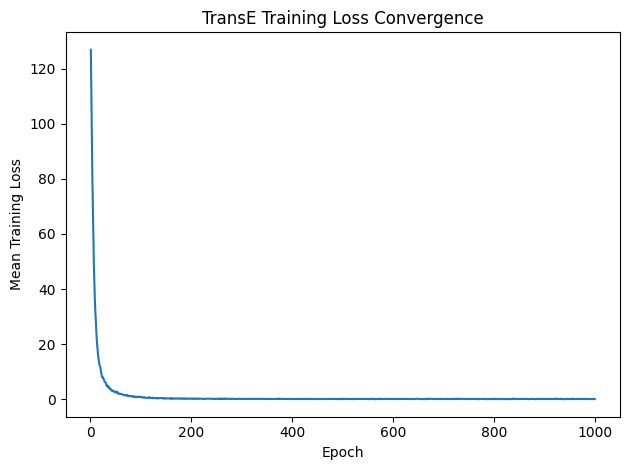

In [24]:
import matplotlib.pyplot as plt

#  绘制折线图
plt.figure()
plt.plot(range(1, n_epochs +1), epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Mean Training Loss')
plt.title('TransE Training Loss Convergence')
plt.tight_layout()
plt.show()

In [25]:
import torch

In [26]:
save_path = "./outputs/transE_openGB500.pt"
torch.save(model.state_dict(), save_path)
print(f"✓ 已保存模型参数到 {save_path}")

✓ 已保存模型参数到 ./outputs/transE_openGB500.pt


In [27]:
from torchkge.evaluation import LinkPredictionEvaluator
from torchkge.utils.pretrained_models import load_pretrained_transe

In [28]:
kg_test = KnowledgeGraph(df=df_test)

In [29]:
model.eval()

TransEModel(
  (ent_emb): Embedding(4562, 100)
  (rel_emb): Embedding(131, 100)
)

In [30]:
if torch.cuda.is_available():
    model.cuda()

### 训练集

In [35]:
kg_train = KnowledgeGraph(df=df_train)
evaluator = LinkPredictionEvaluator(model, kg_train)
evaluator.evaluate(b_size=64)

Link prediction evaluation: 100%|██████████| 137/137 [00:06<00:00, 21.38batch/s]


In [36]:
for i in [1,3,10]:
    print("i = ",i)
    evaluator.print_results(k=i)
    print("-"*100)

i =  1
Hit@1 : 0.471 		 Filt. Hit@1 : 0.785
Mean Rank : 48 	 Filt. Mean Rank : 45
MRR : 0.598 		 Filt. MRR : 0.839
----------------------------------------------------------------------------------------------------
i =  3
Hit@3 : 0.679 		 Filt. Hit@3 : 0.881
Mean Rank : 48 	 Filt. Mean Rank : 45
MRR : 0.598 		 Filt. MRR : 0.839
----------------------------------------------------------------------------------------------------
i =  10
Hit@10 : 0.835 		 Filt. Hit@10 : 0.925
Mean Rank : 48 	 Filt. Mean Rank : 45
MRR : 0.598 		 Filt. MRR : 0.839
----------------------------------------------------------------------------------------------------


### 测试集

In [37]:
evaluator = LinkPredictionEvaluator(model, kg_test)
evaluator.evaluate(b_size=128)

Link prediction evaluation: 100%|██████████| 10/10 [00:00<00:00, 11.08batch/s]


In [38]:
for i in [1,3,10]:
    print("i = ",i)
    evaluator.print_results(k=i)
    print("-"*100)

i =  1
Hit@1 : 0.011 		 Filt. Hit@1 : 0.011
Mean Rank : 2251 	 Filt. Mean Rank : 2251
MRR : 0.013 		 Filt. MRR : 0.013
----------------------------------------------------------------------------------------------------
i =  3
Hit@3 : 0.013 		 Filt. Hit@3 : 0.013
Mean Rank : 2251 	 Filt. Mean Rank : 2251
MRR : 0.013 		 Filt. MRR : 0.013
----------------------------------------------------------------------------------------------------
i =  10
Hit@10 : 0.013 		 Filt. Hit@10 : 0.013
Mean Rank : 2251 	 Filt. Mean Rank : 2251
MRR : 0.013 		 Filt. MRR : 0.013
----------------------------------------------------------------------------------------------------


## DistMult

In [39]:
from torchkge.models import (
    DistMultModel,
    ComplExModel,
)

In [40]:
# Define the model and criterion
DistMult_model = DistMultModel(emb_dim, kg.n_ent, kg.n_rel)
criterion = MarginLoss(margin)

# Move everything to CUDA if available
if cuda.is_available():
    cuda.empty_cache()
    DistMult_model.cuda()
    criterion.cuda()


In [42]:
# Define the torch optimizer to be used
optimizer = Adam(DistMult_model.parameters(), lr=lr, weight_decay=1e-5)

sampler = BernoulliNegativeSampler(kg)
dataloader = DataLoader(kg, batch_size=b_size)

iterator = tqdm(range(n_epochs), unit='epoch')
epoch_losses = []
for epoch in iterator:
    running_loss = 0.0
    for i, batch in enumerate(dataloader):
        h, t, r = batch[0], batch[1], batch[2]
        n_h, n_t = sampler.corrupt_batch(h, t, r)

        optimizer.zero_grad()

        # forward + backward + optimize
        pos, neg = DistMult_model(h, t, r, n_h, n_t)
        loss = criterion(pos, neg)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    mean_loss = running_loss / len(dataloader)
    epoch_losses.append(mean_loss)

    iterator.set_description(
        'Epoch {} | mean loss: {:.5f}'.format(epoch + 1,
                                              running_loss / len(dataloader)))

  0%|          | 0/1000 [00:00<?, ?epoch/s]

Epoch 1000 | mean loss: 0.12841: 100%|██████████| 1000/1000 [01:39<00:00, 10.09epoch/s]


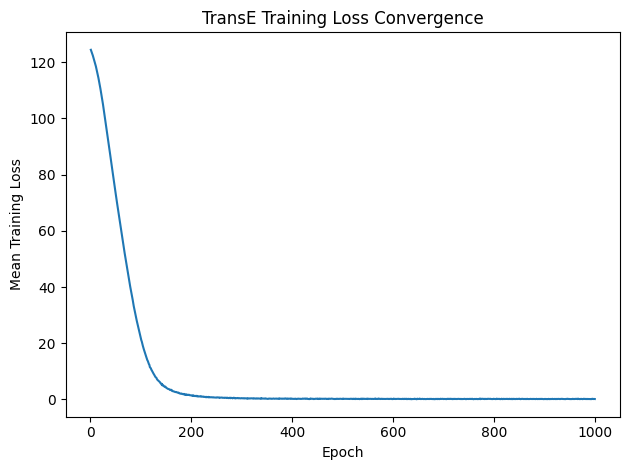

In [43]:
import matplotlib.pyplot as plt

#  绘制折线图
plt.figure()
plt.plot(range(1, n_epochs +1), epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Mean Training Loss')
plt.title('TransE Training Loss Convergence')
plt.tight_layout()
plt.show()

In [44]:
from torchkge.evaluation import LinkPredictionEvaluator
from torchkge.utils.pretrained_models import load_pretrained_transe

DistMult_model.eval()

if torch.cuda.is_available():
    DistMult_model.cuda()

### 训练集

In [45]:
evaluator = LinkPredictionEvaluator(DistMult_model, kg_train)
evaluator.evaluate(b_size=128)

for i in [1,3,10]:
    print("i = ",i)
    evaluator.print_results(k=i)
    print("-"*100)

Link prediction evaluation: 100%|██████████| 69/69 [00:04<00:00, 15.61batch/s]

i =  1
Hit@1 : 0.517 		 Filt. Hit@1 : 0.774
Mean Rank : 11 	 Filt. Mean Rank : 8
MRR : 0.634 		 Filt. MRR : 0.836
----------------------------------------------------------------------------------------------------
i =  3
Hit@3 : 0.704 		 Filt. Hit@3 : 0.881
Mean Rank : 11 	 Filt. Mean Rank : 8
MRR : 0.634 		 Filt. MRR : 0.836
----------------------------------------------------------------------------------------------------
i =  10
Hit@10 : 0.865 		 Filt. Hit@10 : 0.936
Mean Rank : 11 	 Filt. Mean Rank : 8
MRR : 0.634 		 Filt. MRR : 0.836
----------------------------------------------------------------------------------------------------


### 测试集

In [46]:
evaluator = LinkPredictionEvaluator(DistMult_model, kg_test)
evaluator.evaluate(b_size=128)

for i in [1,3,10]:
    print("i = ",i)
    evaluator.print_results(k=i)
    print("-"*100)

Link prediction evaluation: 100%|██████████| 10/10 [00:00<00:00, 16.18batch/s]

i =  1
Hit@1 : 0.001 		 Filt. Hit@1 : 0.001
Mean Rank : 2297 	 Filt. Mean Rank : 2296
MRR : 0.003 		 Filt. MRR : 0.003
----------------------------------------------------------------------------------------------------
i =  3
Hit@3 : 0.001 		 Filt. Hit@3 : 0.001
Mean Rank : 2297 	 Filt. Mean Rank : 2296
MRR : 0.003 		 Filt. MRR : 0.003
----------------------------------------------------------------------------------------------------
i =  10
Hit@10 : 0.006 		 Filt. Hit@10 : 0.006
Mean Rank : 2297 	 Filt. Mean Rank : 2296
MRR : 0.003 		 Filt. MRR : 0.003
----------------------------------------------------------------------------------------------------


## ComplExModel

In [47]:
# Define the model and criterion
ComplEx_model = ComplExModel(emb_dim, kg.n_ent, kg.n_rel)
criterion = MarginLoss(margin)

# Move everything to CUDA if available
if cuda.is_available():
    cuda.empty_cache()
    ComplEx_model.cuda()
    criterion.cuda()


In [48]:
# Define the torch optimizer to be used
optimizer = Adam(ComplEx_model.parameters(), lr=lr, weight_decay=1e-5)

sampler = BernoulliNegativeSampler(kg)
dataloader = DataLoader(kg, batch_size=b_size)

iterator = tqdm(range(n_epochs), unit='epoch')
epoch_losses = []
for epoch in iterator:
    running_loss = 0.0
    for i, batch in enumerate(dataloader):
        h, t, r = batch[0], batch[1], batch[2]
        n_h, n_t = sampler.corrupt_batch(h, t, r)

        optimizer.zero_grad()

        # forward + backward + optimize
        pos, neg = ComplEx_model(h, t, r, n_h, n_t)
        loss = criterion(pos, neg)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    mean_loss = running_loss / len(dataloader)
    epoch_losses.append(mean_loss)

    iterator.set_description(
        'Epoch {} | mean loss: {:.5f}'.format(epoch + 1,
                                              running_loss / len(dataloader)))

  0%|          | 0/1000 [00:00<?, ?epoch/s]

Epoch 1000 | mean loss: 0.09634: 100%|██████████| 1000/1000 [02:04<00:00,  8.05epoch/s]


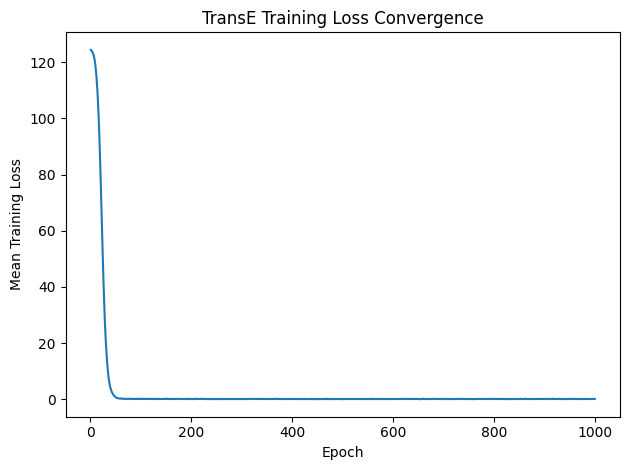

In [49]:
import matplotlib.pyplot as plt

#  绘制折线图
plt.figure()
plt.plot(range(1, n_epochs +1), epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Mean Training Loss')
plt.title('TransE Training Loss Convergence')
plt.tight_layout()
plt.show()

In [50]:
from torchkge.evaluation import LinkPredictionEvaluator
from torchkge.utils.pretrained_models import load_pretrained_transe

ComplEx_model.eval()

if torch.cuda.is_available():
    ComplEx_model.cuda()

### 训练集

In [51]:
evaluator = LinkPredictionEvaluator(ComplEx_model, kg_train)
evaluator.evaluate(b_size=128)

for i in [1,3,10]:
    print("i = ",i)
    evaluator.print_results(k=i)
    print("-"*100)

Link prediction evaluation: 100%|██████████| 69/69 [00:12<00:00,  5.75batch/s]

i =  1
Hit@1 : 0.612 		 Filt. Hit@1 : 0.875
Mean Rank : 4 	 Filt. Mean Rank : 1
MRR : 0.712 		 Filt. MRR : 0.916
----------------------------------------------------------------------------------------------------
i =  3
Hit@3 : 0.776 		 Filt. Hit@3 : 0.951
Mean Rank : 4 	 Filt. Mean Rank : 1
MRR : 0.712 		 Filt. MRR : 0.916
----------------------------------------------------------------------------------------------------
i =  10
Hit@10 : 0.895 		 Filt. Hit@10 : 0.991
Mean Rank : 4 	 Filt. Mean Rank : 1
MRR : 0.712 		 Filt. MRR : 0.916
----------------------------------------------------------------------------------------------------


### 测试集

In [53]:
evaluator = LinkPredictionEvaluator(ComplEx_model, kg_test)
evaluator.evaluate(b_size=128)

for i in [1,3,10]:
    print("i = ",i)
    evaluator.print_results(k=i)
    print("-"*100)

Link prediction evaluation: 100%|██████████| 10/10 [00:01<00:00,  6.26batch/s]

i =  1
Hit@1 : 0.0 		 Filt. Hit@1 : 0.0
Mean Rank : 2224 	 Filt. Mean Rank : 2223
MRR : 0.002 		 Filt. MRR : 0.002
----------------------------------------------------------------------------------------------------
i =  3
Hit@3 : 0.001 		 Filt. Hit@3 : 0.001
Mean Rank : 2224 	 Filt. Mean Rank : 2223
MRR : 0.002 		 Filt. MRR : 0.002
----------------------------------------------------------------------------------------------------
i =  10
Hit@10 : 0.001 		 Filt. Hit@10 : 0.001
Mean Rank : 2224 	 Filt. Mean Rank : 2223
MRR : 0.002 		 Filt. MRR : 0.002
----------------------------------------------------------------------------------------------------


## 过滤

In [54]:
import torch
from torchkge.evaluation import LinkPredictionEvaluator
from torchkge.data_structures import KnowledgeGraph

# 假设你已经有三个 KG：kg_train, kg_val, kg_test
# 1) 先把三部分合成一个“全量”KG（索引必须一致）
kg_full = KnowledgeGraph(
    kg={
        'heads': torch.cat([kg_train.head_idx,  kg_test.head_idx]),
        'tails': torch.cat([kg_train.tail_idx,  kg_test.tail_idx]),
        'relations': torch.cat([kg_train.relations, kg_test.relations]),
    },
    ent2ix=kg_train.ent2ix,   # 保证实体、关系索引映射一致
    rel2ix=kg_train.rel2ix
)

# 2) 在“全量 KG”上预计算用于过滤的字典（哪些替换仍为真）
kg_full.evaluate_dicts()  # 生成 dict_of_heads / dict_of_tails / dict_of_rels

# 3) 把这些“全量字典”赋给测试集 KG
kg_test.dict_of_heads = kg_full.dict_of_heads
kg_test.dict_of_tails = kg_full.dict_of_tails
kg_test.dict_of_rels  = kg_full.dict_of_rels


In [55]:

evaluator = LinkPredictionEvaluator(ComplEx_model, kg_test)
evaluator.evaluate(b_size=128)

for k in [1, 3, 10]:
    evaluator.print_results(k=k)

Link prediction evaluation: 100%|██████████| 10/10 [00:01<00:00,  6.75batch/s]

Hit@1 : 0.0 		 Filt. Hit@1 : 0.0
Mean Rank : 2224 	 Filt. Mean Rank : 2223
MRR : 0.002 		 Filt. MRR : 0.002
Hit@3 : 0.001 		 Filt. Hit@3 : 0.001
Mean Rank : 2224 	 Filt. Mean Rank : 2223
MRR : 0.002 		 Filt. MRR : 0.002
Hit@10 : 0.001 		 Filt. Hit@10 : 0.001
Mean Rank : 2224 	 Filt. Mean Rank : 2223
MRR : 0.002 		 Filt. MRR : 0.002


## all data

### 数据

In [32]:
import os
import pandas as pd
from torchkge.data_structures import KnowledgeGraph

In [33]:

DATA_DIR       = "/root/szl/KG/knowledge_graph_completion/data/OpenBG500"
TRAIN_TSV      = os.path.join(DATA_DIR, "OpenBG500_train.tsv")
DEV_TSV        = os.path.join(DATA_DIR, "OpenBG500_dev.tsv")
TEST_TSV       = os.path.join(DATA_DIR, "OpenBG500_test.tsv")
ENTITY2TEXT    = os.path.join(DATA_DIR, "OpenBG500_entity2text.tsv")
REL2TEXT       = os.path.join(DATA_DIR, "OpenBG500_relation2text.tsv")

In [34]:
# 1. 读所有三元组（ID 格式）
df_train = pd.read_csv(TRAIN_TSV, sep="\t", names=["from","rel","to"], dtype=str)
df_dev   = pd.read_csv(DEV_TSV,   sep="\t", names=["from","rel","to"], dtype=str)
df_test  = pd.read_csv(TEST_TSV,  sep="\t", names=["from","rel","to"], dtype=str)

In [6]:
# 2. 读实体/关系中文描述
ent2text = {}
with open(ENTITY2TEXT, encoding="utf-8") as f:
    for line in f:
        eid, desc = line.strip().split("\t", 1)
        ent2text[eid] = desc

rel2text = {}
with open(REL2TEXT, encoding="utf-8") as f:
    for line in f:
        rid, desc = line.strip().split("\t", 1)
        rel2text[rid] = desc

# 3. 定义一个映射函数
def map_to_text(df):
    df_text = pd.DataFrame({
        "from": df["from"].map(ent2text),
        "rel" : df["rel"].map(rel2text),
        "to"  : df["to"].map(ent2text),
    })
    # 可选：过滤掉任何映射失败的行
    df_text = df_text.dropna().reset_index(drop=True)
    return df_text

In [7]:
# 4. 把训练/验证/测试都映射为中文描述
df_train_text = map_to_text(df_train)
df_dev_text   = map_to_text(df_dev)
df_test_text  = map_to_text(df_test)

In [39]:
df_train_text.to_csv("./df_train_text.csv")
df_dev_text.to_csv("./df_dev_text.csv")
df_test_text.to_csv("./df_test_text.csv")

### 准备

In [1]:
import pandas as pd

In [2]:
df_train = pd.read_csv("./df_train_text.csv")
df_test = pd.read_csv("./df_dev_text.csv")

In [3]:
from torchkge.data_structures import KnowledgeGraph

/root/anaconda3/envs/openke/lib/python3.10/site-packages/torchkge/utils/data_redundancy.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [4]:
kg_train = KnowledgeGraph(df=df_train)
print("实体数:", kg_train.n_ent, "关系数:", kg_train.n_rel, "训练数:", kg_train.n_facts)

实体数: 117311 关系数: 498 训练数: 1242550


In [5]:
df = kg_train.get_df()

In [6]:
df

,from,to,rel
0,苦荞茶,苦荞麦,外部材质
1,精品三姐妹硬糕,原味硬糕850克【10包40块糕】,口味
2,酥念你蛋黄酥,无添蔗糖,细分市场
3,婴儿围嘴,16*10CM*2个,文胸尺码
4,棒球帽,弯檐,檐形
...,...,...,...
1242545,潜水艇防臭地漏,全铜,材质
1242546,男装长裤,浅灰色,颜色分类
1242547,豆奶粉,国产,产地
1242548,地瓜干,否,是否进口


In [7]:
kg_test = KnowledgeGraph(df=df_test)
print("实体数:", kg_test.n_ent, "关系数:", kg_test.n_rel, "训练数:", kg_test.n_facts)

实体数: 4166 关系数: 498 训练数: 5000


### 训练

In [8]:
from torchkge.utils import MarginLoss, DataLoader
from torchkge.models import TransEModel
from torch import cuda
from torch.optim import Adam
from torchkge.utils import MarginLoss, DataLoader
from tqdm.autonotebook import tqdm
from torchkge.sampling import BernoulliNegativeSampler

In [9]:
emb_dim = 50
lr = 0.0004
n_epochs = 1000
b_size = 256
margin = 0.5

In [10]:
# Define the model and criterion
model = TransEModel(emb_dim, kg_train.n_ent, kg_train.n_rel, dissimilarity_type='L2')
criterion = MarginLoss(margin)

# Move everything to CUDA if available
if cuda.is_available():
    cuda.empty_cache()
    model.cuda()
    criterion.cuda()

# Define the torch optimizer to be used
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)

sampler = BernoulliNegativeSampler(kg_train)
dataloader = DataLoader(kg_train, batch_size=b_size, use_cuda='all')



In [11]:
iterator = tqdm(range(n_epochs), unit='epoch')
epoch_losses = []
for epoch in iterator:
    running_loss = 0.0
    for i, batch in enumerate(dataloader):
        h, t, r = batch[0], batch[1], batch[2]
        n_h, n_t = sampler.corrupt_batch(h, t, r)

        optimizer.zero_grad()

        # forward + backward + optimize
        pos, neg = model(h, t, r, n_h, n_t)
        loss = criterion(pos, neg)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    mean_loss = running_loss / len(dataloader)
    epoch_losses.append(mean_loss)

    iterator.set_description(
        'Epoch {} | mean loss: {:.5f}'.format(epoch + 1,
                                              running_loss / len(dataloader)))

Epoch 1000 | mean loss: 2.94146: 100%|██████████| 1000/1000 [4:14:51<00:00, 15.29s/epoch]


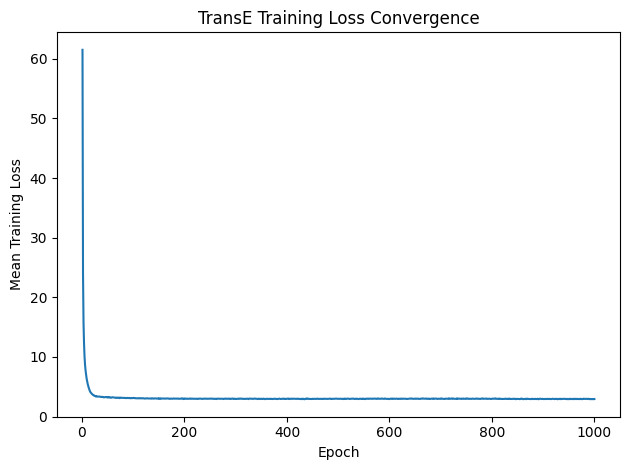

In [12]:
import matplotlib.pyplot as plt

#  绘制折线图
plt.figure()
plt.plot(range(1, n_epochs +1), epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Mean Training Loss')
plt.title('TransE Training Loss Convergence')
plt.tight_layout()
plt.show()

In [23]:
evaluator = LinkPredictionEvaluator(model, kg_train)
evaluator.evaluate(b_size=128)

Link prediction evaluation:   0%|          | 2/9708 [00:00<17:11,  9.41batch/s]

Link prediction evaluation: 100%|██████████| 9708/9708 [13:57<00:00, 11.59batch/s]


In [24]:
evaluator.print_results()

Hit@10 : 0.101 		 Filt. Hit@10 : 0.114
Mean Rank : 35044 	 Filt. Mean Rank : 34933
MRR : 0.056 		 Filt. MRR : 0.066


In [13]:
import torch
save_path = "./outputs/transE_openGB500_0613.pt"
torch.save(model.state_dict(), save_path)
print(f"✓ 已保存模型参数到 {save_path}")

✓ 已保存模型参数到 ./outputs/transE_openGB500_0613.pt


In [14]:
from torchkge.evaluation import LinkPredictionEvaluator
from torchkge.utils.pretrained_models import load_pretrained_transe

In [15]:
kg_test = KnowledgeGraph(df=df_test)

In [20]:
kg_test.get_df()

,from,to,rel
0,葡萄干,否,是否有核
1,运动内衣,中国,品牌归属地
2,新路学业口算题卡一年级上,同步训练,教辅种类
3,男子汉牙刷A62,清洁,功能
4,月子服,长袖,袖长
...,...,...,...
4995,特级初榨橄榄油,初榨橄榄油,食用油类型
4996,5.5“英式反口碗,10件,套件数量
4997,户外垃圾桶,剪裁，压制，折弯后在焊接而成型,制作工艺
4998,imoo学习手机GET香槟金,英文,语种分类


In [16]:
model.eval()

TransEModel(
  (ent_emb): Embedding(117311, 50)
  (rel_emb): Embedding(498, 50)
)

In [17]:
if torch.cuda.is_available():
    model.cuda()

In [18]:
evaluator = LinkPredictionEvaluator(model, kg_test)
evaluator.evaluate(b_size=128)

Link prediction evaluation: 100%|██████████| 40/40 [00:02<00:00, 15.78batch/s]


In [19]:
for i in [1,3,10]:
    print("i = ",i)
    evaluator.print_results(k=i)
    print("-"*100)

i =  1
Hit@1 : 0.0 		 Filt. Hit@1 : 0.0
Mean Rank : 52051 	 Filt. Mean Rank : 52049
MRR : 0.0 		 Filt. MRR : 0.0
----------------------------------------------------------------------------------------------------
i =  3
Hit@3 : 0.0 		 Filt. Hit@3 : 0.0
Mean Rank : 52051 	 Filt. Mean Rank : 52049
MRR : 0.0 		 Filt. MRR : 0.0
----------------------------------------------------------------------------------------------------
i =  10
Hit@10 : 0.0 		 Filt. Hit@10 : 0.0
Mean Rank : 52051 	 Filt. Mean Rank : 52049
MRR : 0.0 		 Filt. MRR : 0.0
----------------------------------------------------------------------------------------------------


In [21]:
evaluator.print_results()

Hit@10 : 0.0 		 Filt. Hit@10 : 0.0
Mean Rank : 52051 	 Filt. Mean Rank : 52049
MRR : 0.0 		 Filt. MRR : 0.0
